## Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [304]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [305]:
tqdm.pandas()

In [268]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.float_format = None

In [4]:
from fastai.learner import *
from fastai.column_data import *
from fastai.structured import *

In [5]:
path = './data/'

In [6]:
!ls {path}

item_categories.csv   sales_train.csv       shops.csv
items.csv             sample_submission.csv test.csv


In [7]:
item_categories = pd.read_csv(f'{path}item_categories.csv')
train = pd.read_csv(f'{path}sales_train.csv')
shops = pd.read_csv(f'{path}shops.csv')
items = pd.read_csv(f'{path}items.csv')

In [21]:
test = pd.read_csv(f'{path}test.csv')

## Helper Functions

In [8]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on == None: 
        right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=('', suffix))

## Analysis

In [8]:
train.sample(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1581774,17.04.2014,15,6,11242,399.0,1.0
975025,03.10.2013,9,53,19643,399.0,1.0
1769615,27.06.2014,17,37,3077,799.0,1.0
805640,22.08.2013,7,28,15319,999.0,1.0
2146715,19.11.2014,22,18,13405,20999.0,1.0
477863,30.05.2013,4,30,15106,999.0,1.0
2055259,05.10.2014,21,5,3331,799.0,1.0
678391,30.07.2013,6,19,17368,98.0,1.0
1041196,12.11.2013,10,27,1832,1199.0,1.0
264136,09.03.2013,2,54,19694,149.0,1.0


In [11]:
len(shops)

60

In [12]:
items.sample(5)

,item_name,item_id,item_category_id
11996,ИНТЕРВЕНЦИЯ (rem),11996,40
2304,"Call of Duty: Black Ops Declassified [PS Vita,...",2304,22
11508,ЖИТЕЛИ ОКЕАНОВ-1,11508,40
18994,СОСЕДИ НА ТРОПЕ ВОЙНЫ,18994,40
20276,ФИЛОСОФЫ. УРОК ВЫЖИВАНИЯ,20276,40


In [13]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [9]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')

In [10]:
min_date = train.date.min()
train['days_elapsed'] = train.date.map(lambda x: (x-min_date).days)

In [57]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,days_elapsed,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
2909818,2015-10-28,33,12,11373,0.908714,2169.0,1030,2015,10,44,28,2,301,False,False,False,False,False,False,1445990400


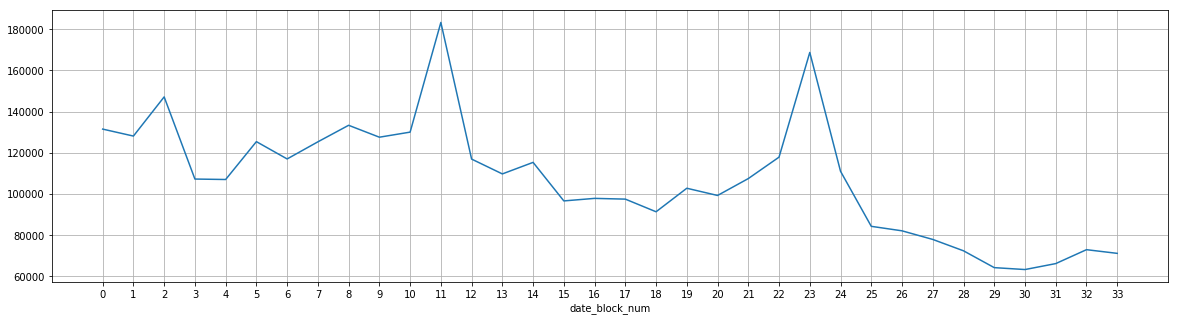

In [69]:
train.groupby('date_block_num')['item_cnt_day'].sum().plot(figsize=(20,5), grid=True, xticks=range(0,34))

In [62]:
item_counts = train.groupby('item_id')['item_cnt_day'].sum()
item_counts.sort_values(ascending=False, inplace=True)

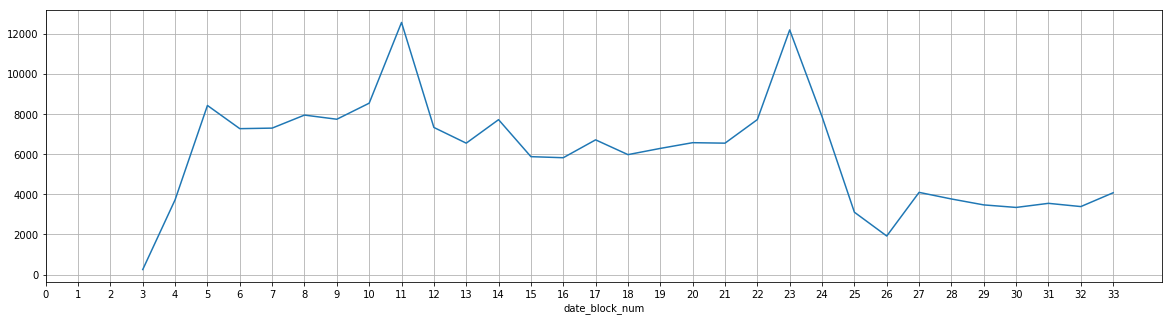

In [68]:
train[train.item_id == item_counts.index[0]].groupby('date_block_num')['item_cnt_day'].sum().plot(figsize=(20,5), grid=True, xticks = range(0,34))

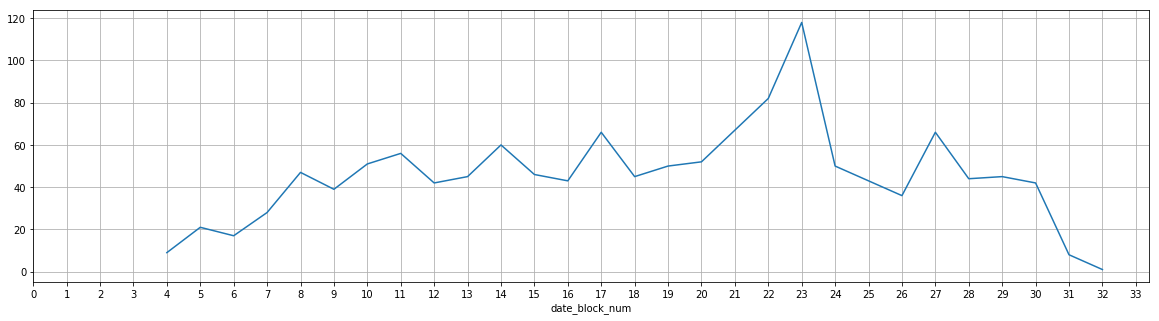

In [85]:
train[(train.item_id == item_counts.index[0]) & (train.shop_id==2)].groupby('date_block_num')['item_cnt_day'].sum().plot(figsize=(20,5), grid=True, xticks = range(0,34))

In [81]:
item_shop_counts = train.groupby(['item_id', 'shop_id']).size()

In [87]:
sum(item_shop_counts < 20)/len(item_shop_counts)

0.9277192519168922

In [92]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,days_elapsed,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,item_name,item_category_id
0,2015-10-28,33,12,11373,0.908714,2169.0,1030,2015,10,44,28,2,301,False,False,False,False,False,False,1445990400,Доставка до пункта выдачи (Boxberry),9


In [91]:
train = join_df(train, items, 'item_id')

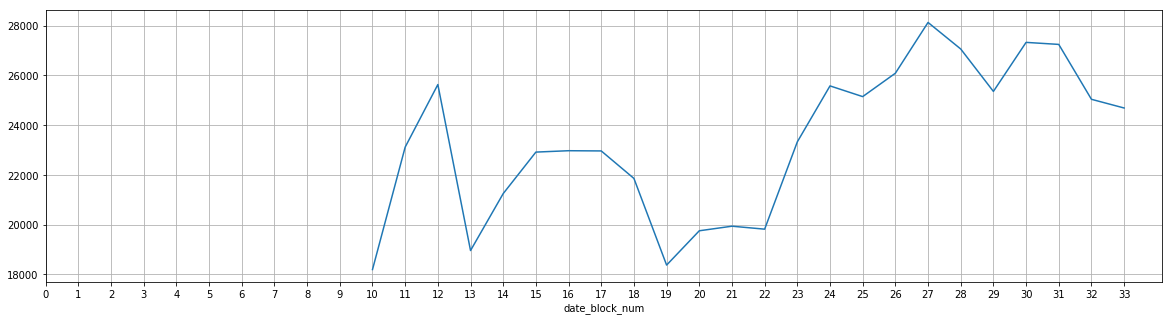

In [99]:
train[(train.item_id == item_counts.index[6])].groupby('date_block_num')['item_price'].mean().plot(figsize=(20,5), grid=True, xticks = range(0,34))

In [100]:
monthly_counts = train.groupby(['item_id', 'shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index()

In [101]:
monthly_counts.sort_values('date_block_num', inplace=True)

In [102]:
monthly_counts.head(1)

,item_id,shop_id,date_block_num,item_cnt_day
747775,9607,46,0,1.0


In [105]:
category_counts = train.groupby('item_category_id')['item_id'].nunique()

In [109]:
category_months_unique = train.groupby('item_category_id')['date_block_num'].nunique()

In [111]:
category_months_unique.sort_values()

item_category_id
52     1
51     1
50     1
10     1
1      2
0      3
53     3
36     3
48     4
27     5
80     6
18     6
42     7
47     8
46    10
8     11
26    11
74    13
68    13
7     14
24    14
13    15
17    15
34    16
32    16
16    16
81    19
66    20
39    20
82    21
59    23
20    24
12    24
54    30
76    30
31    30
44    30
78    30
4     31
69    34
79    34
75    34
58    34
61    34
70    34
62    34
63    34
73    34
64    34
65    34
77    34
67    34
72    34
71    34
60    34
57    34
41    34
55    34
2     34
3     34
5     34
6     34
9     34
11    34
14    34
15    34
19    34
21    34
22    34
56    34
23    34
28    34
29    34
30    34
33    34
35    34
37    34
38    34
40    34
43    34
45    34
49    34
25    34
83    34
Name: date_block_num, dtype: int64

In [114]:
sorted(train[train.item_category_id==17]['date_block_num'].unique())

[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

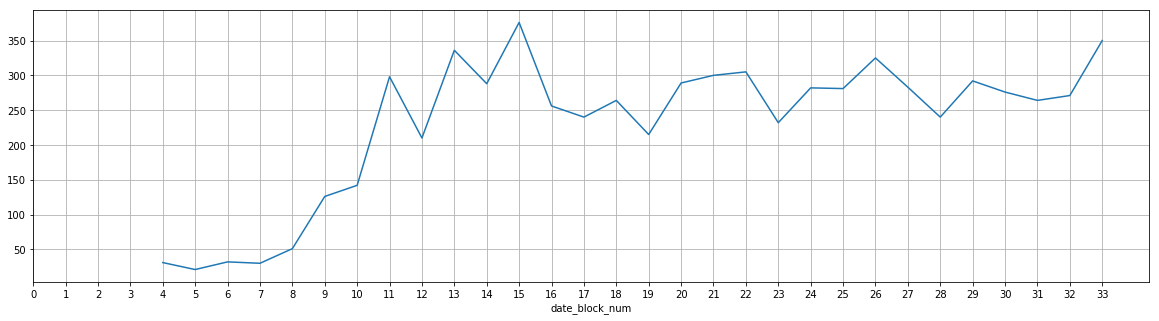

In [116]:
train[train.item_category_id==54].groupby('date_block_num')['item_cnt_day'].sum().plot(figsize=(20,5), grid=True, xticks=range(0,34))

In [117]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,days_elapsed,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,item_name,item_category_id
0,2015-10-28,33,12,11373,0.908714,2169.0,1030,2015,10,44,28,2,301,False,False,False,False,False,False,1445990400,Доставка до пункта выдачи (Boxberry),9


In [118]:
day_subset = train[['date_block_num', 'Day', 'Dayofweek']].copy()

In [119]:
day_subset.drop_duplicates(['date_block_num', 'Day'], inplace=True)

In [123]:
day_subset.sort_values(['date_block_num', 'Day'], inplace=True)

In [124]:
day_subset

,date_block_num,Day,Dayofweek
2170,0,1,1
323,0,2,2
4454,0,3,3
7341,0,4,4
5871,0,5,5
9435,0,6,6
7479,0,7,0
10500,0,8,1
10273,0,9,2
28354,0,10,3


In [127]:
day_weights = train.groupby(['Dayofweek'])['item_cnt_day'].sum()/sum(train.item_cnt_day)

In [128]:
train['day_weight'] = train.Dayofweek.map(day_weights)

In [130]:
day_subset['day_weight'] = day_subset.Dayofweek.map(day_weights)

In [131]:
month_weights = day_subset.groupby(['date_block_num'])['day_weight'].sum()

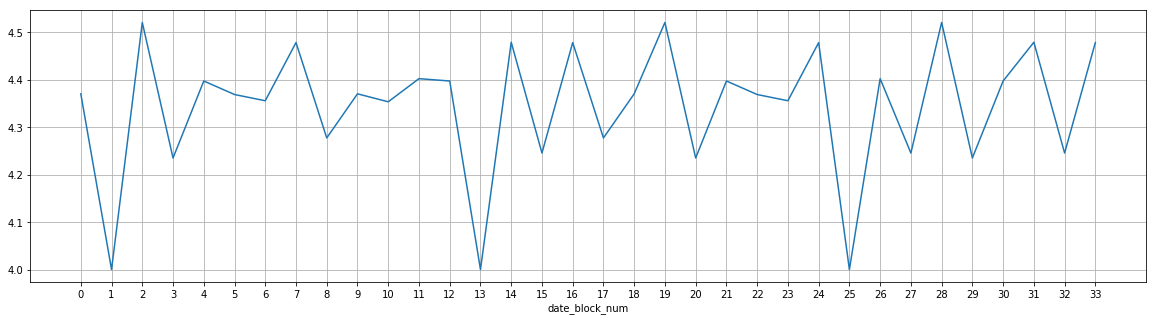

In [132]:
month_weights.plot(figsize=(20,5), grid=True, xticks=range(0,34))

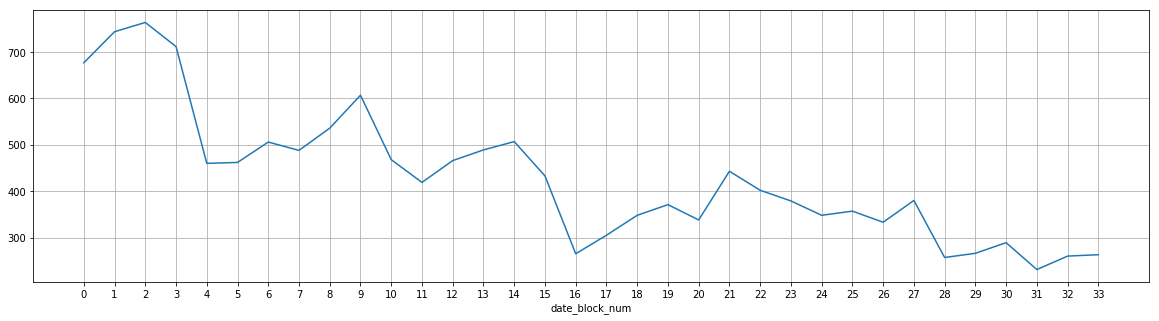

In [134]:
train[train.item_category_id==73].groupby('date_block_num')['item_cnt_day'].sum().plot(figsize=(20,5), grid=True, xticks=range(0,34))

## Data Preparation

In [272]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,days_elapsed,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,item_name,item_category_id,day_weight,emon,etue,ewed,ethu,efri,esat,esun,ewday
0,2015-10-28,33,12,11373,0.908714,2169.0,1030,2015,10,44,28,2,301,False,False,False,False,False,False,1445990400,Доставка до пункта выдачи (Boxberry),9,0.120529,True,True,True,False,False,False,True,1


In [140]:
extra_day_type = (day_subset.groupby('date_block_num')['Dayofweek'].value_counts().unstack() == 4)

In [141]:
extra_day_type.columns = ['emon', 'etue', 'ewed', 'ethu', 'efri', 'esat', 'esun']

In [147]:
extra_day_type['ewday'] = extra_day_type['efri'].astype(int) + extra_day_type['esat'].astype(int) + extra_day_type['esun'].astype(int)

In [149]:
extra_day_type.reset_index(inplace=True)

In [153]:
month_counts = train.groupby(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'Year'])['item_cnt_day'].sum().reset_index()

In [155]:
month_counts = join_df(month_counts, extra_day_type, 'date_block_num')

In [156]:
month_counts.head(1)

,date_block_num,shop_id,item_id,item_category_id,Year,item_cnt_day,emon,etue,ewed,ethu,efri,esat,esun,ewday
0,0,0,32,40,2013,6.0,True,False,False,False,True,True,True,3


In [157]:
month_counts.to_csv(f'{path}simple_model_train.csv', index=False, header=True)

In [159]:
test = join_df(test, items, 'item_id')

In [163]:
test['date_block_num'] = 34
test['Year'] = 2015
test[['emon', 'etue', 'ewed', 'ethu', 'efri', 'esat', 'esun']] = pd.DataFrame([[True, False, False, False, False, False, True]], index=test.index)

In [165]:
test['ewday'] = test['efri'].astype(int) + test['esat'].astype(int) + test['esun'].astype(int)

In [166]:
test.head(1)

,ID,shop_id,item_id,item_name,item_category_id,date_block_num,Year,emon,etue,ewed,ethu,efri,esat,esun,ewday
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,34,2015,True,False,False,False,False,False,True,1


In [167]:
test.drop('item_name', axis=1, inplace=True)

In [168]:
test.to_csv(f'{path}simple_model_test.csv', index=False, header=True)

## Plots

In [169]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,days_elapsed,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,item_name,item_category_id,day_weight,emon,etue,ewed,ethu,efri,esat,esun,ewday
0,2015-10-28,33,12,11373,0.908714,2169.0,1030,2015,10,44,28,2,301,False,False,False,False,False,False,1445990400,Доставка до пункта выдачи (Boxberry),9,0.120529,True,True,True,False,False,False,True,1


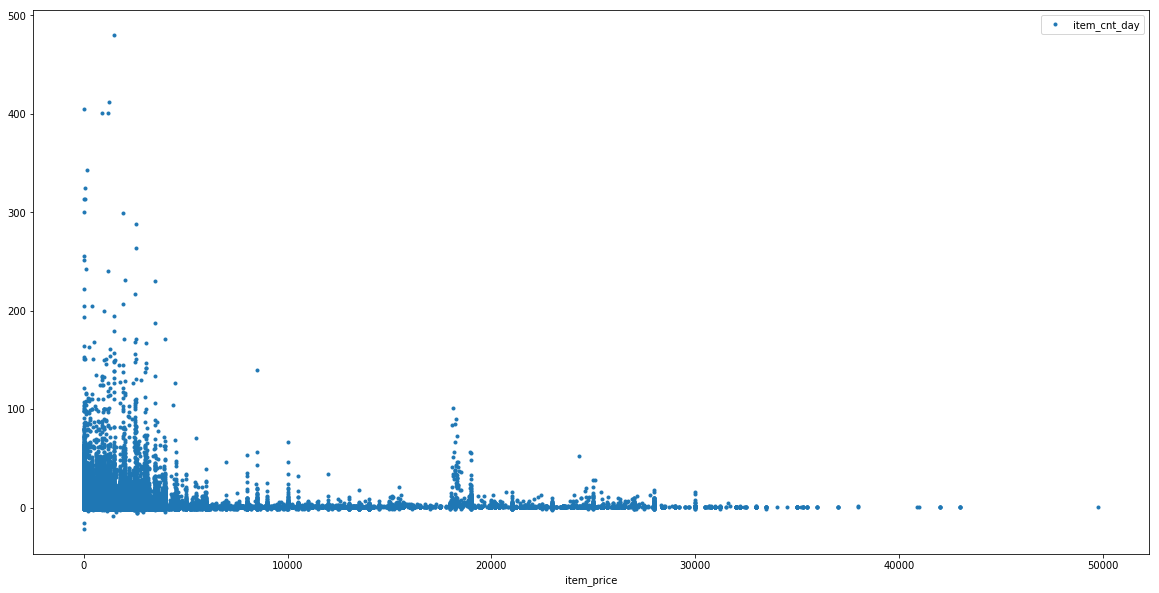

In [172]:
train[(train.item_price < 50000) & (train.item_cnt_day < 500)].plot(x='item_price', y='item_cnt_day', style='.', figsize=(20,10))

In [189]:
subzero_day_counts = train[train.item_cnt_day < 0].groupby('date').size()
day_counts = train.groupby('date').size()

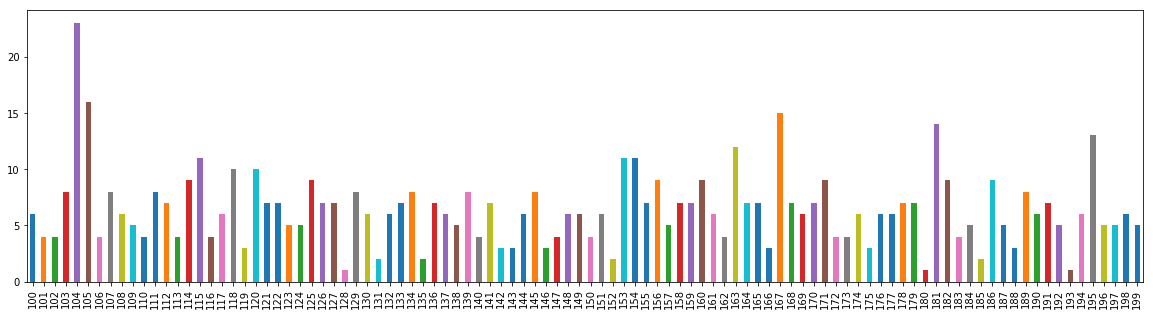

In [205]:
pd.DataFrame(subzero_day_counts).reset_index().iloc[100:200][0].plot(kind='bar', figsize=(20,5))

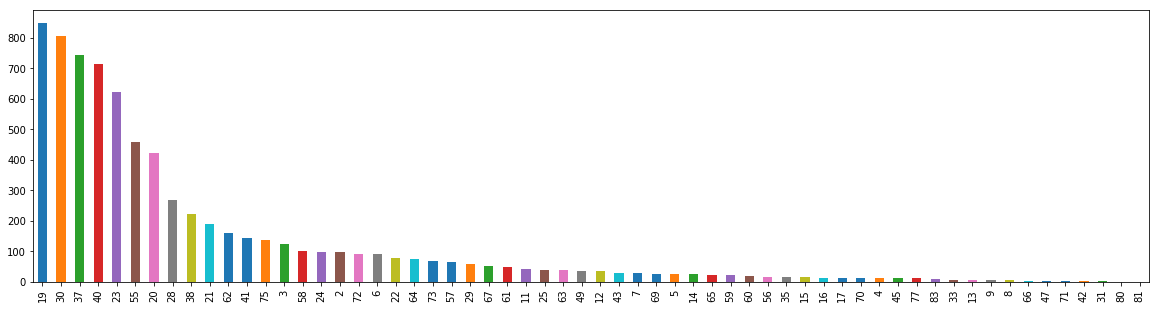

In [212]:
train[train.item_cnt_day < 0].item_category_id.value_counts().plot(kind='bar', figsize=(20,5))

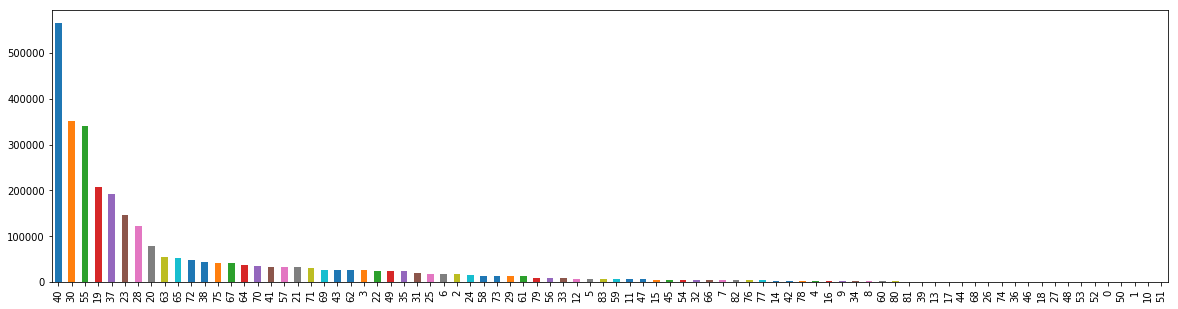

In [213]:
train.item_category_id.value_counts().plot(kind='bar', figsize=(20,5))

In [225]:
train[(train.item_cnt_day < -1) & (train.item_category_id == 19)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,days_elapsed,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,item_name,item_category_id,day_weight,emon,etue,ewed,ethu,efri,esat,esun,ewday
2935750,2014-02-13,13,3,4353,1899.0,-2.0,408,2014,2,7,13,3,44,False,False,False,False,False,False,1392249600,"LEGO Marvel Super Heroes [PS3, русские субтитры]",19,0.124615,True,True,True,True,True,True,True,3
2935754,2013-04-26,3,12,5208,2399.0,-2.0,115,2013,4,17,26,4,116,False,False,False,False,False,False,1366934400,Naruto Shippuden: Ultimate Ninja Storm 3 Day 1...,19,0.151706,False,False,True,True,True,True,True,3
2935757,2013-04-02,3,12,5287,2199.0,-2.0,91,2013,4,14,2,1,92,False,False,False,False,False,False,1364860800,"Ni no Kuni: Wrath of the White Witch [PS3, анг...",19,0.124715,False,False,True,True,True,True,True,3
2935762,2015-03-09,26,57,4051,1999.0,-2.0,797,2015,3,11,9,0,68,False,False,False,False,False,False,1425859200,"Just Dance 2015 (только для PS Move) [PS3, рус...",19,0.110051,False,False,True,True,True,True,False,2
2935768,2013-10-31,9,12,3732,2469.0,-2.0,303,2013,10,44,31,3,304,True,False,False,False,False,False,1383177600,"Grand Theft Auto V [PS3, русские субтитры]",19,0.124615,True,False,False,False,True,True,True,3
2935773,2013-10-19,9,42,16787,2599.0,-2.0,291,2013,10,42,19,5,292,False,False,False,False,False,False,1382140800,"Одни из нас [PS3, русская версия]",19,0.201372,True,False,False,False,True,True,True,3
2935778,2013-08-08,7,12,1946,499.0,-2.0,219,2013,8,32,8,3,220,False,False,False,False,False,False,1375920000,"BioShock Ultimate Rapture Edition [PS3, англий...",19,0.124615,True,True,True,False,False,False,True,1
2935789,2014-02-26,13,6,5031,249.0,-2.0,421,2014,2,9,26,2,57,False,False,False,False,False,False,1393372800,"NHL 12 [PS3, русские субтитры]",19,0.120529,True,True,True,True,True,True,True,3
2935791,2014-02-28,13,50,2446,599.5,-2.0,423,2014,2,9,28,4,59,True,False,False,False,False,False,1393545600,"Crysis 3 [PS3, русская версия]",19,0.151706,True,True,True,True,True,True,True,3
2935793,2014-06-02,17,12,7799,3699.0,-2.0,517,2014,6,23,2,0,153,False,False,False,False,False,False,1401667200,"Watch_Dogs. Vigilante Edition [PS3, русская ве...",19,0.110051,False,True,True,True,True,True,False,2


In [227]:
train[(train.item_id == 3732) & (train.shop_id == 12)][['item_cnt_day', 'date']].sort_values('date')

,item_cnt_day,date
123,106.0,2013-09-17
1321,33.0,2013-09-18
24271,6.0,2013-09-19
1719,30.0,2013-09-20
96589,3.0,2013-09-23
96590,3.0,2013-09-24
2623127,1.0,2013-09-25
2623126,1.0,2013-09-26
43089,4.0,2013-09-27
264175,2.0,2013-09-28


In [228]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,days_elapsed,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,item_name,item_category_id,day_weight,emon,etue,ewed,ethu,efri,esat,esun,ewday
0,2015-10-28,33,12,11373,0.908714,2169.0,1030,2015,10,44,28,2,301,False,False,False,False,False,False,1445990400,Доставка до пункта выдачи (Boxberry),9,0.120529,True,True,True,False,False,False,True,1


In [231]:
shop_counts = train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum()

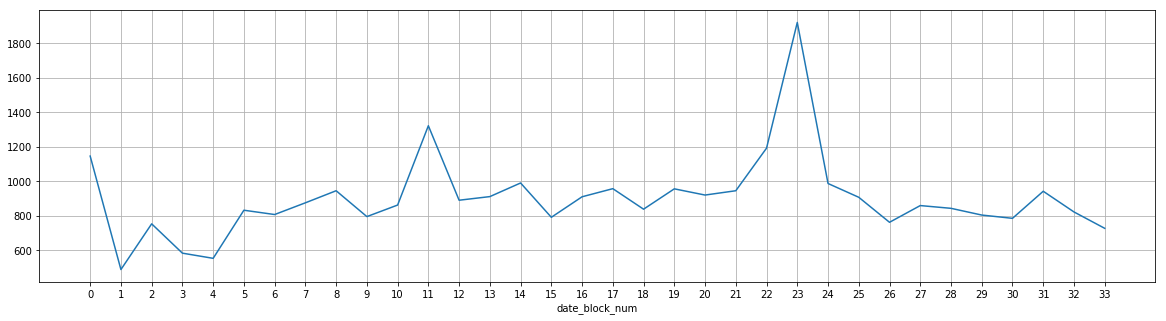

In [236]:
shop_counts[2].plot(figsize=(20,5), grid=True, xticks=range(0,34))

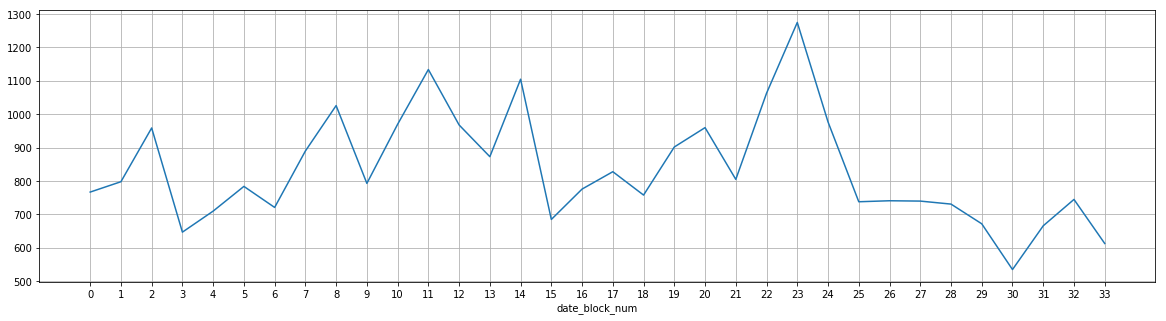

In [237]:
shop_counts[3].plot(figsize=(20,5), grid=True, xticks=range(0,34))

In [243]:
corr = train.corr()

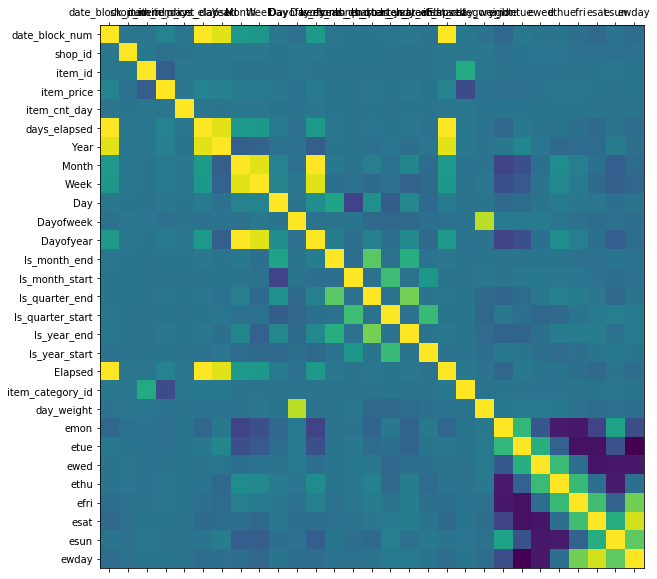

In [246]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)

plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

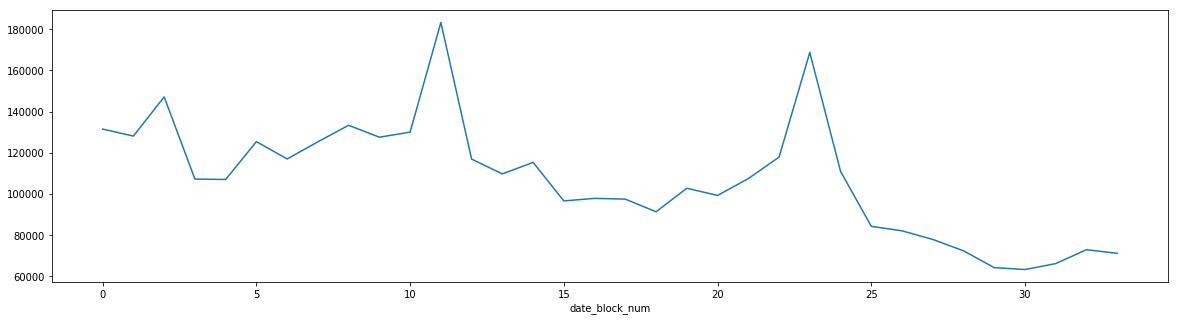

In [247]:
train.groupby(['date_block_num'])['item_cnt_day'].sum().plot(figsize=(20,5))

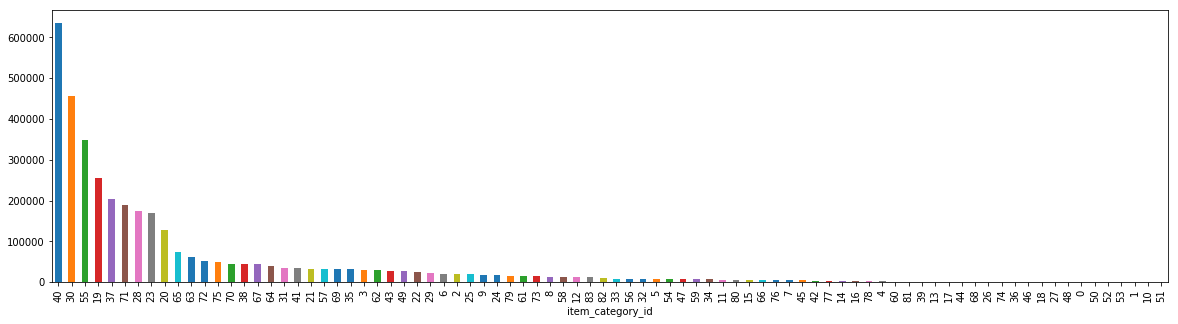

In [250]:
train.groupby(['item_category_id'])['item_cnt_day'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(20,5))

In [251]:
item_category_counts = train.groupby(['item_category_id'])['item_cnt_day'].sum()

In [269]:
item_category_counts.sort_values(ascending=False)/train.item_cnt_day.sum()

item_category_id
40    1.738309e-01
30    1.251410e-01
55    9.555135e-02
19    6.986639e-02
37    5.572163e-02
71    5.153163e-02
28    4.795617e-02
23    4.658290e-02
20    3.489907e-02
65    2.003094e-02
63    1.668108e-02
72    1.414969e-02
75    1.321855e-02
70    1.235319e-02
38    1.234360e-02
67    1.214378e-02
64    1.078804e-02
31    9.623360e-03
41    9.267569e-03
21    9.063633e-03
57    8.958650e-03
69    8.742653e-03
35    8.564209e-03
3     8.170317e-03
62    7.933488e-03
43    7.289884e-03
49    7.261103e-03
22    6.886398e-03
29    6.166318e-03
6     5.611525e-03
2     5.371681e-03
25    5.355509e-03
9     4.966277e-03
24    4.628576e-03
79    4.339119e-03
61    4.169172e-03
73    3.994566e-03
8     3.754996e-03
58    3.736357e-03
12    3.626440e-03
83    3.298059e-03
82    2.860858e-03
33    2.355678e-03
56    2.269883e-03
32    2.036069e-03
5     2.031958e-03
54    1.892985e-03
47    1.884762e-03
59    1.812124e-03
34    1.807738e-03
11    1.755109e-03
80    1.681923

In [261]:
shop_counts = train.groupby('shop_id')['item_cnt_day'].sum().sort_values(ascending=False)

In [271]:
shop_counts/sum(shop_counts)

shop_id
31    0.085186
25    0.066312
54    0.050926
28    0.050588
42    0.039727
57    0.038678
27    0.037459
6     0.027545
58    0.022404
46    0.021652
56    0.021402
50    0.020897
12    0.020141
19    0.020135
15    0.019517
35    0.018918
21    0.018793
26    0.018609
47    0.018540
7     0.018381
18    0.017950
24    0.017512
55    0.017375
53    0.016901
16    0.016894
30    0.016673
22    0.016509
29    0.016094
38    0.014771
43    0.013872
52    0.013635
41    0.013520
59    0.013429
51    0.013367
14    0.012712
37    0.012679
44    0.012318
4     0.012045
5     0.011721
45    0.011484
2     0.008393
3     0.007772
17    0.007082
48    0.006828
10    0.006722
13    0.005417
49    0.004684
39    0.004555
9     0.004349
0     0.003208
32    0.002407
23    0.002112
34    0.001768
1     0.001730
20    0.001610
33    0.001503
40    0.001355
8     0.000985
11    0.000157
36    0.000090
Name: item_cnt_day, dtype: float64

In [275]:
item_occurs = train.groupby('item_id')['date_block_num'].nunique()

In [283]:
sum(item_occurs < 10)/len(item_occurs)

0.5239601962672537

## Prev Time Step Features

In [284]:
train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,days_elapsed,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,item_name,item_category_id,day_weight,emon,etue,ewed,ethu,efri,esat,esun,ewday
0,2015-10-28,33,12,11373,0.908714,2169.0,1030,2015,10,44,28,2,301,False,False,False,False,False,False,1445990400,Доставка до пункта выдачи (Boxberry),9,0.120529,True,True,True,False,False,False,True,1


In [286]:
month_counts.sort_values('date_block_num', inplace=True)

In [290]:
month_counts['last_month_cnt'] = month_counts.groupby(['shop_id', 'item_id'])['item_cnt_day'].shift(1)

In [293]:
month_counts['last_month_cnt'].isnull().sum()/len(month_counts)

0.0

In [292]:
month_counts['last_month_val_null'] = month_counts['last_month_cnt'].isnull()
month_counts['last_month_cnt'].fillna(0, inplace=True)

In [308]:
last_mon_val = defaultdict(tuple)

In [309]:
def last_val(row):
    key = (row['shop_id'], row['item_id'])
    val = 0
    if len(last_mon_val[key]) > 0:
        if last_mon_val[key][0] == row['date_block_num'] - 1:
            val = last_mon_val[key][1]
    last_mon_val[key] = (row['date_block_num'], row['item_cnt_day'])
    return val

In [310]:
month_counts['last_month_cnt'] = month_counts.progress_apply(last_val, axis=1)

HBox(children=(IntProgress(value=0, max=1609124), HTML(value='')))

In [311]:
month_counts['last_month_val_null'] = (month_counts['last_month_cnt'] == 0)

In [313]:
month_counts.drop('last_val_pair', axis=1, inplace=True)

In [314]:
month_counts.to_csv(f'{path}simple_model_train.csv', index=False, header=True)